In [2]:
import sys 
sys.path.append("../")

import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sn
import numpy as np
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import umap
import sklearn
import pandas as pd 
from core.utils import (find_non_numerical_columns,categorize_columns,
                   convert_df_to_numeric_df,scale_columns,evaluate_model)
%load_ext autoreload
%autoreload 2



/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/gregoryscafarto/ecovadis/.venv/lib64/python3.11/site-pac

In [4]:
df = pd.read_excel("../data/assignement.xlsx")
target = df["Exited"]
numerical_df = convert_df_to_numeric_df(df,["RowNumber", "CustomerId", "Surname","CustomerFeedback","Exited"])
scaled_df = scale_columns(numerical_df,columns=["EstimatedSalary","Balance (EUR)","CreditScore","Age","Tenure"])


In [6]:
scaled_df.head()

,EstimatedSalary,Balance (EUR),CreditScore,Age,Tenure,NumberOfProducts,HasCreditCard,IsActiveMember,Country_cat,Gender_cat
0,0.797217,1.354197,2.001803,-1.994969,-1.041760,1,0,0,0,1
1,0.468183,1.206470,0.056609,-1.994969,1.724464,1,0,1,0,1
2,-0.491732,0.100675,-0.833213,-1.994969,-0.350204,1,1,0,0,0
3,1.690765,0.837543,0.677416,-1.994969,-0.695982,1,0,0,1,0
4,-0.924205,0.914583,0.791230,-1.994969,-0.350204,1,1,1,0,1


In [5]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_df)

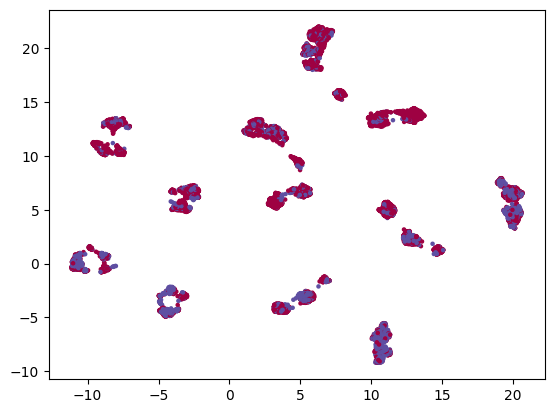

In [6]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=target.values, cmap='Spectral', s=5)

No clear separation between exited and non exited items unfortunetly

## Random Forest Baseline

#### Split data

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(scaled_df, target.values, test_size=0.2, random_state=0, stratify=target.values)

In [8]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

In [9]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

 balanced accuracy is 0.5282555282555282
 AUC is 0.5282555282555282


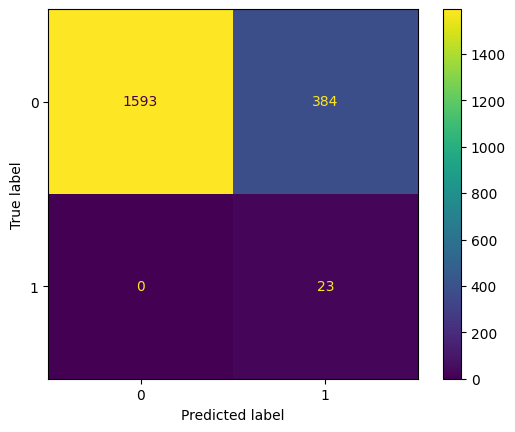

In [20]:
accuracy = evaluate_model(X_test,y_test,clf)

In [12]:
scores = cross_val_score(clf, scaled_df, target.values,scoring = "balanced_accuracy", cv=5)
predicted_values = clf.predict(X_test)

#### HP tunning 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False] 
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2)
rf_random.fit(X_train, y_train)

In [ ]:
#best_rf_model = rf_random.best_estimator_

Best hyperparmeters are : max_depth=70, max_features='sqrt', min_samples_leaf=2,min_samples_split=10, n_estimators=1600 

In [15]:
best_rf_model = RandomForestClassifier(max_depth=70, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=1600)

In [17]:
best_rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=70, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=1600)

 balanced accuracy is 0.6955275768835091
 AUC is 0.6955275768835091


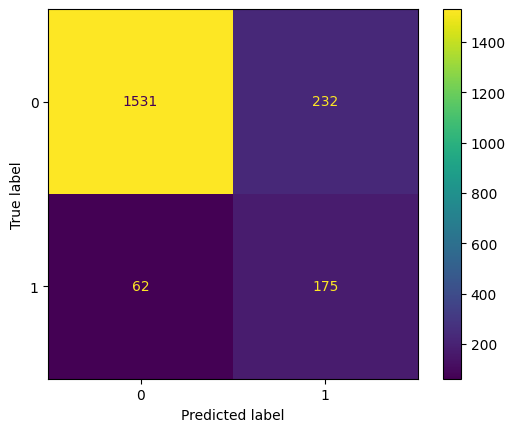

In [19]:
accuracy = evaluate_model(X_test,y_test,best_rf_model)